<table style="float:left">
    <tr>
        <td>
            <img src="images/emlyon.png" style="height:60px; float:left; padding-right:10px; margin-top:5px" />
        </td>
        <td style="">
            <div style="display:inline-block; float:left; text-align:left; width:500px;">
            <h1 style="border-bottom: 1px solid #eeeeee; display:table-cell; padding-bottom:5px;"> Introduction to Deep Learning </h1>
            <a style="" href="https://em-lyon.com/">[emlyon]</a> business school    
            <br/>
            Lyon, Paris | © Saeed VARASTEH
            </div>
        </td>
    </tr>
</table>

<div class="alert-info" style="border-bottom: solid 1px lightgray; background-color:#ece4f5;">
    <img src="images/assignment.png" style="height:60px; float:left; padding-right:10px;" />
    <span style="font-weight:bold; color:#8966b0">
        <h4 style="padding-top:25px;"> FINAL PROJECT </h4>
    </span>
</div>

###  DSAIS Speaker Recognition Application


In this project, you'll build a speaker recognition system to recognize your friends voices.

Let us return to Homework 02. Remember that we built a __fully connected model__ over __averaged mfcc vectors__ extracted from your speech samples? 

Review the questions I asked you at the end of this homework. Now you are able to answer those questions.

__Your task: Improve your speaker recognition model__.

How can you improve the model? The answer is simple: Find a better way to represent the input and extract features from it.

- See if you can play with the parameters of the MFCC extraction function. More MFCC features, or different Mel filter bank parameters (__melkwargs__), or even extracting other speech-related features.

- Currently, we are averaging all MFCC vectors from the signal. It is better to try a different strategy. For example, you can keep a sequence of MFCC features and try RNN models.

- Use existing pre-trained models for audio/speech signals to extract the features from your audio signals. Add a classification head to the model and similar to what we did in our transfer learning session, train the new model. Great speech models are available in "speechbrain", "torchaudio" and "pyannote" libraries.

__Test the model__:

You can use Homework 02 codes as a baseline. To test the model, use three of your friends to see if the model can accurately guess the speaker.

__Extra step (high bounce!)__:

- Build a Python application that recognizes speakers. I will show you how and give an example in class.

- EDA, Apply PCA to embeddings of voices and visualize them, etc. are optional and will increase your score.

Good Luck!

---

In [ ]:
# your code!

In [1]:
# import
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
import sounddevice as sd
from scipy.io.wavfile import write
import IPython.display as ipd

# from utils.py
from utils import (
    device, 
    SequenceSpeakerDataset, 
    SpeakerRecognitionRNN, 
    collate_fn, 
    train_rnn_model, 
    predict_speaker, 
    visualize_embeddings,
    convert_mp3_to_wav
)

C:\Users\timot\AppData\Roaming\Python\Python310\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
print(f"Using device: {device}")

Using device: cpu


In [3]:
root_dir = "../data/Speakers/train/"

In [4]:
convert_mp3_to_wav(root_dir)

Processing of -- ../data/Speakers/train/abdoulaye
Processing of -- ../data/Speakers/train/abhishek
Processing of -- ../data/Speakers/train/adam
Processing of -- ../data/Speakers/train/adesh
Processing of -- ../data/Speakers/train/agathe
Processing of -- ../data/Speakers/train/arisa
Processing of -- ../data/Speakers/train/arthur
Processing of -- ../data/Speakers/train/ayoub
Processing of -- ../data/Speakers/train/camille
Processing of -- ../data/Speakers/train/charlotte
Processing of -- ../data/Speakers/train/dilara
Processing of -- ../data/Speakers/train/ekaterina
Processing of -- ../data/Speakers/train/ella
Processing of -- ../data/Speakers/train/hadi
Processing of -- ../data/Speakers/train/henry
Processing of -- ../data/Speakers/train/himanshu
Processing of -- ../data/Speakers/train/hugo
Processing of -- ../data/Speakers/train/jermiah
Processing of -- ../data/Speakers/train/jintian
Processing of -- ../data/Speakers/train/joaquin
Processing of -- ../data/Speakers/train/kp
Processing o

In [10]:
max_length = 300
batch_size = 32

In [11]:
full_dataset = SequenceSpeakerDataset(root_dir, max_length=max_length)
num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {full_dataset.classes}")
print(f"Mapping classes -> indexes: {full_dataset.class_to_idx}")

Number of classes: 34
Classes: ['abdoulaye', 'abhishek', 'adam', 'adesh', 'agathe', 'arisa', 'arthur', 'ayoub', 'camille', 'charlotte', 'dilara', 'ekaterina', 'ella', 'hadi', 'henry', 'himanshu', 'hugo', 'jermiah', 'jintian', 'joaquin', 'kp', 'lou', 'marysheeba', 'matilde', 'maude', 'piercarlo', 'saeed', 'sicheng', 'siwen', 'tim', 'walid', 'yanlin', 'yiwei', 'yuying']
Mapping classes -> indexes: {'abdoulaye': 0, 'abhishek': 1, 'adam': 2, 'adesh': 3, 'agathe': 4, 'arisa': 5, 'arthur': 6, 'ayoub': 7, 'camille': 8, 'charlotte': 9, 'dilara': 10, 'ekaterina': 11, 'ella': 12, 'hadi': 13, 'henry': 14, 'himanshu': 15, 'hugo': 16, 'jermiah': 17, 'jintian': 18, 'joaquin': 19, 'kp': 20, 'lou': 21, 'marysheeba': 22, 'matilde': 23, 'maude': 24, 'piercarlo': 25, 'saeed': 26, 'sicheng': 27, 'siwen': 28, 'tim': 29, 'walid': 30, 'yanlin': 31, 'yiwei': 32, 'yuying': 33}


In [12]:
# split train/val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [13]:
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [14]:
n_epochs = 40
hidden_size = 64
learning_rate = 0.001

model = SpeakerRecognitionRNN(
    input_size=40,
    hidden_size=hidden_size,
    num_layers=1,
    num_classes=num_classes,
    dropout=0.5
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Training...")
train_losses, train_accs, val_losses, val_accs = train_rnn_model(
    model, train_loader, val_loader, criterion, optimizer, n_epochs, device
)

Training...
Epoch: 05
	Train Loss: 2.890 | Train Acc: 0.181
	 Val. Loss: 3.358 |  Val. Acc: 0.297
Epoch: 10
	Train Loss: 2.344 | Train Acc: 0.537
	 Val. Loss: 2.860 |  Val. Acc: 0.500
Epoch: 15
	Train Loss: 1.873 | Train Acc: 0.750
	 Val. Loss: 2.456 |  Val. Acc: 0.516
Epoch: 20
	Train Loss: 1.460 | Train Acc: 0.894
	 Val. Loss: 2.254 |  Val. Acc: 0.562
Epoch: 25
	Train Loss: 1.234 | Train Acc: 0.912
	 Val. Loss: 1.968 |  Val. Acc: 0.609
Epoch: 30
	Train Loss: 0.966 | Train Acc: 0.944
	 Val. Loss: 1.791 |  Val. Acc: 0.641
Epoch: 35
	Train Loss: 0.912 | Train Acc: 0.981
	 Val. Loss: 1.506 |  Val. Acc: 0.906
Epoch: 40
	Train Loss: 0.632 | Train Acc: 1.000
	 Val. Loss: 1.379 |  Val. Acc: 0.938


In [15]:
# save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': full_dataset.class_to_idx,
    'classes': full_dataset.classes
}, 'speaker_recognition_model.pth')
print("Model save with succes!")

Model save with succes!


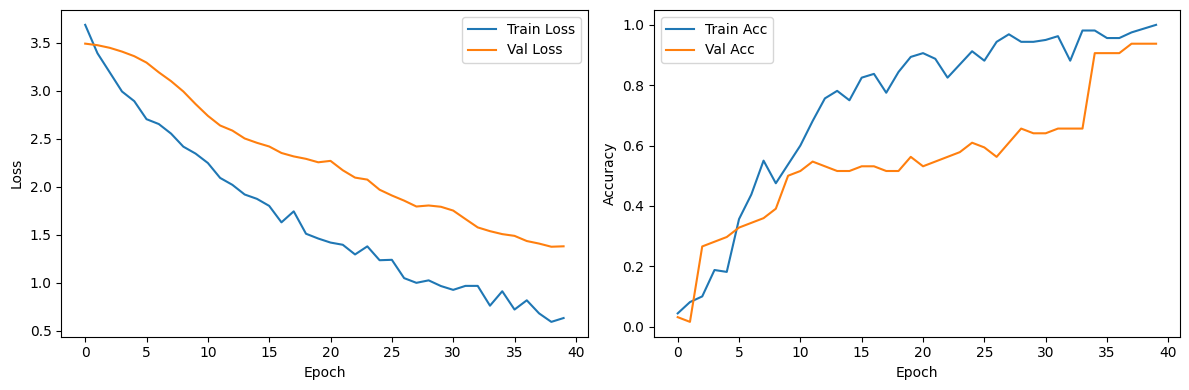

In [16]:
# plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

Generating embedding visualizations with PCA...


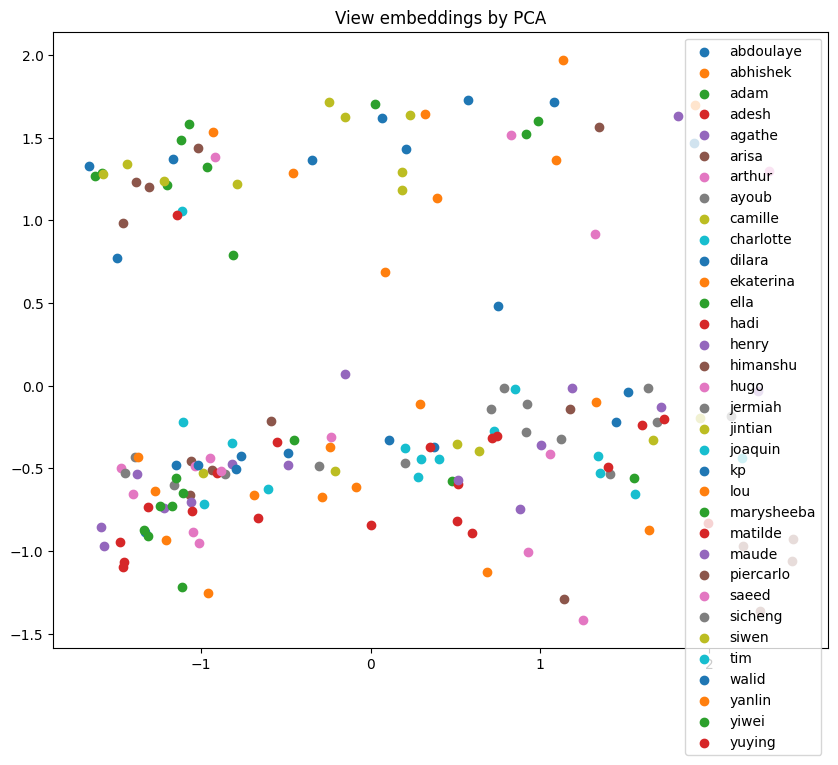

In [17]:
#  embeddings with PCA
print("Generating embedding visualizations with PCA...")
pca_plot = visualize_embeddings(model, full_dataset, device, method='pca')
pca_plot.show()

Generating embedding visualizations with t-SNE...


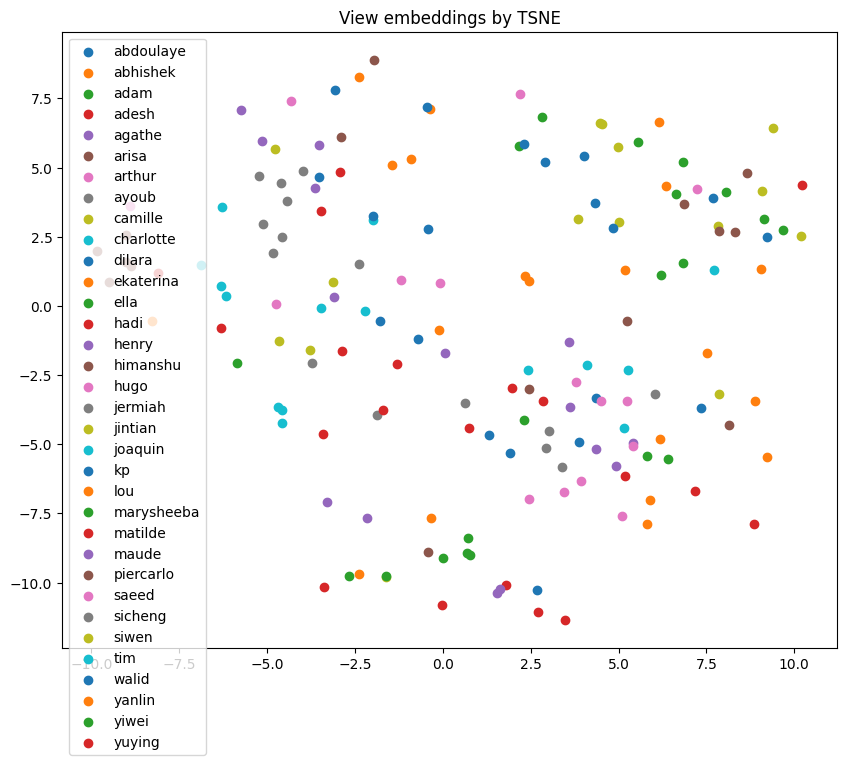

In [18]:
# embeddings with t-SNE
print("Generating embedding visualizations with t-SNE...")
tsne_plot = visualize_embeddings(model, full_dataset, device, method='tsne')
tsne_plot.show()

In [19]:
# record an audio file
def record_sample(duration=10, sample_rate=48000, output_path="./output.wav"):
    print("Say something...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()
    
    print("Recording complete. Save...")
    write(output_path, sample_rate, audio)
    print(f"Saved in {output_path}")
    
    return output_path

In [ ]:
try:
    sd.query_devices()
    test_path = record_sample()
    
    print("Listening to the recorded sample:")
    ipd.display(ipd.Audio(test_path))
    
    print("Prediction of the speaker:")
    class_names = {i: name for i, name in enumerate(full_dataset.classes)}
    predictions = predict_speaker(model, test_path, class_names, device)
    
    for speaker, prob in predictions:
        print(f"Speaker predicted: {speaker}")
        print(f"Probabilitie: {prob:.2f}%")
except Exception as e:
    print(f"Recording or test error: {e}")

Say something...
Recording complete. Save...
Saved in ./output.wav
Listening to the recorded sample:


Prediction of the speaker:
Speaker predicted: himanshu
Probabilitie: 11.88%
Speaker predicted: kp
Probabilitie: 10.31%
Speaker predicted: jermiah
Probabilitie: 9.13%


In [21]:
# tester avec un fichier audio existant
def test_existing_audio(file_path):
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist.")
        return
    
    print(f"Audio file playback: {file_path}")
    ipd.display(ipd.Audio(file_path))
    
    print("Prediction of the speaker:")
    class_names = {i: name for i, name in enumerate(full_dataset.classes)}
    predictions = predict_speaker(model, file_path, class_names, device)
    
    for speaker, prob in predictions:
        print(f"Pedicted speaker: {speaker}")
        print(f"Probabilitie: {prob:.2f}%")

# tester avec un exemple du dataset
if len(full_dataset) > 0:
    sample_path, _ = full_dataset.samples[0]
    print(f"Test with an example dataset: {sample_path}")
    test_existing_audio(sample_path)

Test with an example dataset: ../data/Speakers/train/abdoulaye\sentence_1.wav
Audio file playback: ../data/Speakers/train/abdoulaye\sentence_1.wav


Prediction of the speaker:
Pedicted speaker: abdoulaye
Probabilitie: 22.66%
Pedicted speaker: hadi
Probabilitie: 4.53%
Pedicted speaker: arthur
Probabilitie: 4.40%


---